In [9]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from plots.chapter3 import *
from v4 import StepByStep

### Are my data points separable?

That's the million-dollar question! In the example above, we can clearly see that data points in the validation set are **more separable** than those in the training set.

What happens if the points are **not separable at all**? Let's take a quick detour and look at another tiny dataset with 10 data points, seven red, three blue. The colors are the **labels (_y_)**, and each data point has a **single feature (_x~1~_)**. We could plot them **along a line**; after all, we have only **one dimension**.

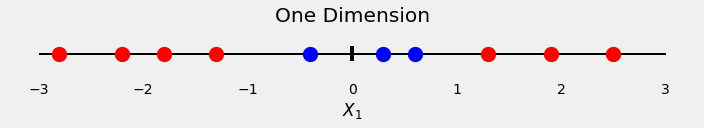

In [5]:
x = np.array([-2.8, -2.2, -1.8, -1.3, -.4, 0.3, 0.6, 1.3, 1.9, 2.5])
y = np.array([0., 0., 0., 0., 1., 1., 1., 0., 0., 0.])

fig = one_dimension(x, y)

Can you **separate the blue points from the red ones with one straight line**? Obviously not—these points **are not separable** (in one dimension, that is).

Should we give up, then?

---

"_Never give up, never surrender!_"

[Commander Taggart](https://i.imgflip.com/51toa2.jpg)


---

If it doesn't work in one dimension, try using two! There is just one problem, though: Where does the other dimension come from? We can use a **trick** here: We apply a **function** to the **original dimension (feature)** and use the result as a **second dimension (feature)**. Quite simple, right?

For the tiny dataset at hand, we could try the **square function**:


$$
\Large X_2 = f(X_1)= X_1^2
$$

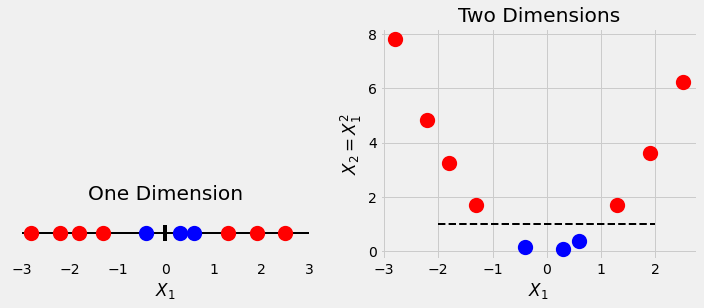

In [6]:
fig = two_dimensions(x, y)

Back to the original question: "_Can you separate the blue points from the red ones with one straight line?_"

In two dimensions, that's a piece of cake!

---

**The more dimensions, the more separable the points are.**

---

It is beyond the scope of this book to explain _why_ this trick works. The important thing is to **understand the general idea**: As the **number of dimensions increases**, there is **more and more empty space**. If the data points are farther apart, it is likely easier to separate them. In two dimensions, the decision boundary is a line. In three dimensions, it is a plane. In four dimensions and more, it is a hyper-plane (fancier wording for a plane you can't draw).

Have you heard of the **kernel trick** for support vector machines (SVMs)? That's pretty much what it does! The **kernel** is nothing but the **function** we use to create additional dimensions. The square function we used is a **polynomial**, so we used a **polynomial kernel**.

"_Why are we talking about SVMs?_"

Excellent question! It turns out **neural networks** may also **increase the dimensionality**. That's what happens if you add a **hidden layer** with **more units** than the **number of features**.

In [33]:
# Data Preparation

dummy_x = torch.as_tensor(x).view(-1, 1).float()
dummy_y = torch.as_tensor(y).view(-1, 1).float()

dummy_ds = TensorDataset(dummy_x, dummy_y)
dummy_dl = DataLoader(dummy_ds, batch_size=5, shuffle=True)

torch.manual_seed(42)

#########################
## Model Configuration ##
#########################
lr = 1e-1
dummy_model = nn.Sequential()
dummy_model.add_module('hidden', nn.Linear(1, 2))
dummy_model.add_module('activation', nn.ReLU())
dummy_model.add_module('output', nn.Linear(2, 1))
dummy_model.add_module('sigmoid', nn.Sigmoid())
loss_fn = nn.BCELoss()
optimizer = optim.SGD(dummy_model.parameters(), lr)

####################
## Model Training ##
####################
sbs = StepByStep(dummy_model, loss_fn, optimizer)
sbs.set_loaders(dummy_dl)
sbs.train(100)

In [27]:
dummy_model.to('cpu')

Sequential(
  (hidden): Linear(in_features=1, out_features=2, bias=True)
  (activation): ReLU()
  (output): Linear(in_features=2, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

The model above increases dimensionality **from one dimension** (one feature) to **two dimensions** and then uses those **ten dimensions to compute logits**. But it **only works if there is an activation function between the layers**. 

In [28]:
dummy_model(dummy_x), dummy_y

(tensor([[0.2723],
         [0.2723],
         [0.2736],
         [0.3717],
         [0.5714],
         [0.7149],
         [0.5797],
         [0.2501],
         [0.0899],
         [0.0284]], grad_fn=<SigmoidBackward>),
 tensor([[0.],
         [0.],
         [0.],
         [0.],
         [1.],
         [1.],
         [1.],
         [0.],
         [0.],
         [0.]]))

In [29]:
out = dummy_model.output.state_dict()
out

OrderedDict([('weight', tensor([[-1.6629,  1.1290]])),
             ('bias', tensor([-0.9829]))])

$$
\Large x_2 = -\frac{b}{w_2} - \frac{w_1}{w_2}x_1
$$

In [30]:
b = (-out['bias']/out['weight'][0][1]).numpy()
w = (-out['weight'][0][0]/out['weight'][0][1]).numpy()
boundary = lambda x: b + w * x
b, w

(array([0.87062865], dtype=float32), array(1.472875, dtype=float32))

(-0.2, 6.0)

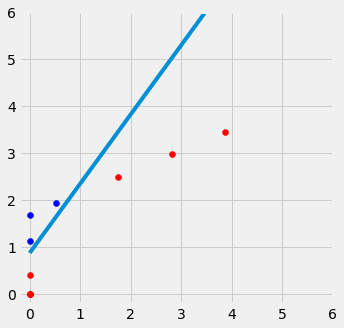

In [31]:
hidden_feat = nn.ReLU()(dummy_model.hidden(dummy_x)).tolist()
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(*np.array(hidden_feat)[y==0].T, c='red')
ax.scatter(*np.array(hidden_feat)[y==1].T, c='blue')
ax.plot([0, 6], [boundary(0), boundary(6)])
ax.set_xlim([-.2, 6])
ax.set_ylim([-.2, 6])

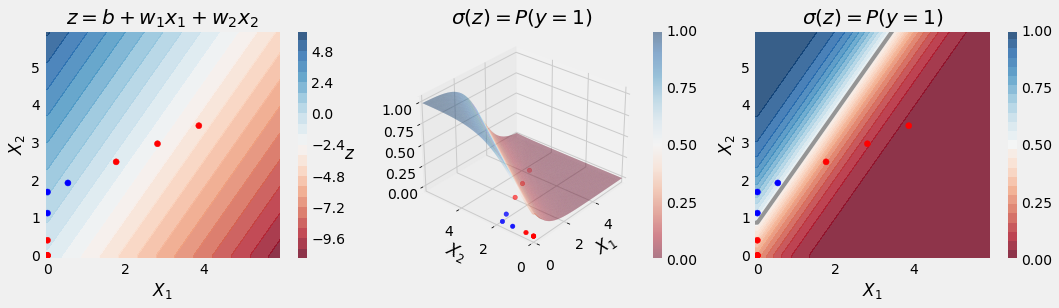

In [32]:
fig = figure7(nn.ReLU()(dummy_model.hidden(dummy_x)).detach(), 
              dummy_y, 
              nn.Sequential(*list(dummy_model.children())[1:-1]), 
              'cpu', x_range=(-.1, 6), y_range=(-.1, 6))